In [1]:
import numpy as np
import time
import pickle as pk

# Declarando constantes

In [9]:
h = 0.05
k = 0.1
Db = 0.0001
Dn = 0.0001
phi = 0.2
ksi = 0.0
cb = 0.15
lambd_nb = 1.8
mi_n = 0.2
lambd_bn = 0.1
y_n = 0.1
Cn_max = 0.5
X_nb = 1e-4
x_dom = (0, 1)
y_dom = (0, 1)
t_dom = (0, 10)

size_x = int(((x_dom[1] - x_dom[0]) / (h)))
size_y = int(((y_dom[1] - y_dom[0]) / (h)))
size_tt = int(((t_dom[1] - t_dom[0]) / (k)))


print("Size x = {:d}, y = {:d} \n ".format(size_x, size_y))

print(
    "Steps in time = {:d}\nSteps in space_x = {:d}\nSteps in space_y = {:d}\n".format(
        size_tt,
        size_x,
        size_y,
    )
)

CFL = (Db * k) / ((2 * (h * h)))

print("CFL: ", CFL)
if CFL >= 1:
    print("Criterio não satisfeito")

Size x = 20, y = 20 
 
Steps in time = 100
Steps in space_x = 20
Steps in space_y = 20

CFL:  0.0019999999999999996


In [11]:
def fb(Cb, Cn):
    return (cb - lambd_nb * Cn) * Cb


def fn(Cb, Cn, Cn_max):
    return y_n * Cb * (Cn_max - Cn) - lambd_bn * Cn * Cb - mi_n * Cn


def phix(Cbipj, Cbimj, Cbij, i, j, tam_max):
    ax = (Cbipj - Cbimj) / (2 * h)

    if (i == 0 or i == tam_max - 1) or (j == 0 or j == tam_max - 1) or (ax == 0):
        return 0

    elif ax > 0:
        return (ax * k / h) * (Cbij - Cbimj)

    elif ax < 0:
        return (ax * k / h) * (Cbipj - Cbij)


def phiy(Cbijp, Cbijm, Cbij, i, j, tam_max):
    ax = (Cbijp - Cbijm) / (2 * h)

    if (i == 0 or i == tam_max - 1) or (j == 0 or j == tam_max - 1) or (ax == 0):
        return 0

    elif ax > 0:
        return (ax * k / h) * (Cbij - Cbijm)

    elif ax < 0:
        return (ax * k / h) * (Cbijp - Cbij)


def apply_initial_conditions(Cb, tam_max):
    for i in range(tam_max):
        for j in range(tam_max):
            if (i * h >= 0.4) and (i * h) <= 0.6:
                if (j * h >= 0.4) and (j * h) <= 0.6:
                    Cb[i][j] = 0.2

    return Cb


def solve_pde():
    size_x = int(((x_dom[1] - x_dom[0]) / (h)) + 1)
    size_y = int(((y_dom[1] - y_dom[0]) / (h)) + 1)
    size_tt = int(((t_dom[1] - t_dom[0]) / (k)) + 1)

    Cn_new = np.zeros((size_x, size_y))
    Cb_new = np.zeros((size_x, size_y))

    Cn_final = np.zeros((size_tt, size_x, size_y))
    Cb_final = np.zeros((size_tt, size_x, size_y))

    Cb_new = apply_initial_conditions(Cb_new, size_x)

    Cb_final[0] = Cb_new
    Cn_final[0] = Cn_new

    u_a = u_b = u_c = u_d = 0

    r_n = (Dn * k) / (phi * (h * h))
    r_b = (Db * k) / (phi * (h * h))

    for time in range(1, size_tt):
        Cn_old = Cn_new.copy()
        Cb_old = Cb_new.copy()
        for i in range(size_x):
            for j in range(size_y):
                # Tratando Cb
                if j == size_y - 1:
                    Cb_uijp = 2 * h * u_c + Cb_old[i][size_y - 1]

                else:
                    Cb_uijp = Cb_old[i][j + 1]
                if j == 0:
                    Cb_uijm = 2 * h * u_a + Cb_old[i][1]

                else:
                    Cb_uijm = Cb_old[i][j - 1]

                if i == size_x - 1:
                    Cb_uipj = 2 * h * u_d + Cb_old[size_x - 1][j]
                else:
                    Cb_uipj = Cb_old[i + 1][j]
                if i == 0:
                    Cb_uimj = 2 * h * u_b * Cb_old[1][j]
                else:
                    Cb_uimj = Cb_old[i - 1][j]

                # Tratando Cn
                if j == size_y - 1:
                    Cn_uijp = 2 * h * u_c + Cn_old[i][size_y - 1]
                else:
                    Cn_uijp = Cn_old[i][j + 1]
                #
                if j == 0:
                    Cn_uijm = 2 * h * u_a + Cn_old[i][1]
                else:
                    Cn_uijm = Cn_old[i][j - 1]
                #
                if i == size_x - 1:
                    Cn_uipj = 2 * h * u_d + Cn_old[size_x - 1][j]
                else:
                    Cn_uipj = Cn_old[i + 1][j]
                #
                if i == 0:
                    Cn_uimj = 2 * h * u_b * Cn_old[1][j]
                else:
                    Cn_uimj = Cn_old[i - 1][j]

                Cb_new[i][j] = (
                    r_b * (Cb_uimj + Cb_uipj - 4 * Cb_old[i][j] + Cb_uijp + Cb_uijm)
                    + (k / phi) * (fb(Cb_old[i][j], Cn_old[i][j]))
                    + Cb_old[i][j]
                )

                Cn_new[i][j] = (
                    r_n * (Cn_uimj + Cn_uipj - 4 * Cn_old[i][j] + Cn_uijp + Cn_uijm)
                    + (k / phi) * (fn(Cb_old[i][j], Cn_old[i][j], Cn_max))
                    + Cn_old[i][j]
                    + ksi
                    * (
                        -phix(Cb_uipj, Cb_uimj, Cb_old[i][j], i, j, size_x)
                        - phiy(Cb_uijp, Cb_uijm, Cb_old[i][j], i, j, size_y)
                    )
                )

                Cb_final[time][i][j] = Cb_new[i][j]
                Cn_final[time][i][j] = Cn_new[i][j]

    return Cb_final, Cn_final

In [12]:
Cb, Cn = solve_pde()

In [13]:
struct_name = (
    "h--"
    + str(h)
    + "__k--"
    + str(k)
    + "__Db--"
    + str(Db)
    + "__Dn--"
    + str(Dn)
    + "__phi--"
    + str(phi)
    + "__ksi--"
    + str(ksi)
    + "__cb--"
    + str(cb)
    + "__lambd_nb--"
    + str(lambd_nb)
    + "__mi_n--"
    + str(mi_n)
    + "__lambd_bn--"
    + str(lambd_bn)
    + "__y_n--"
    + str(y_n)
    + "__Cn_max--"
    + str(Cn_max)
    + "__X_nb--"
    + str(Cn_max)
    + "__x_dom_min--"
    + str(x_dom[0])
    + "__x_dom_max--"
    + str(x_dom[-1])
    + "__y_dom_min--"
    + str(y_dom[0])
    + "__y_dom_max--"
    + str(y_dom[-1])
    + "__t_dom_min--"
    + str(t_dom[0])
    + "__t_dom_max--"
    + str(t_dom[-1])
)

print("struct_name: ", struct_name)

with open("fdm_sim/Cp__" + struct_name + ".pkl", "wb") as f:
    pk.dump(Cb, f)

with open("fdm_sim/Cl__" + struct_name + ".pkl", "wb") as f:
    pk.dump(Cn, f)

struct_name:  h--0.05__k--0.1__Db--0.0001__Dn--0.0001__phi--0.2__ksi--0.0__cb--0.15__lambd_nb--1.8__mi_n--0.2__lambd_bn--0.1__y_n--0.1__Cn_max--0.5__X_nb--0.5__x_dom_min--0__x_dom_max--1__y_dom_min--0__y_dom_max--1__t_dom_min--0__t_dom_max--10


In [6]:
fdm_time = []

for i in range(10):

    start = time.time()

    solve_pde()

    end = time.time()

    run_time = start - end

    fdm_time.append(run_time)

with open("fdm_sim/time__" + struct_name + ".pkl", "wb") as f:
    pk.dump(fdm_time, f)

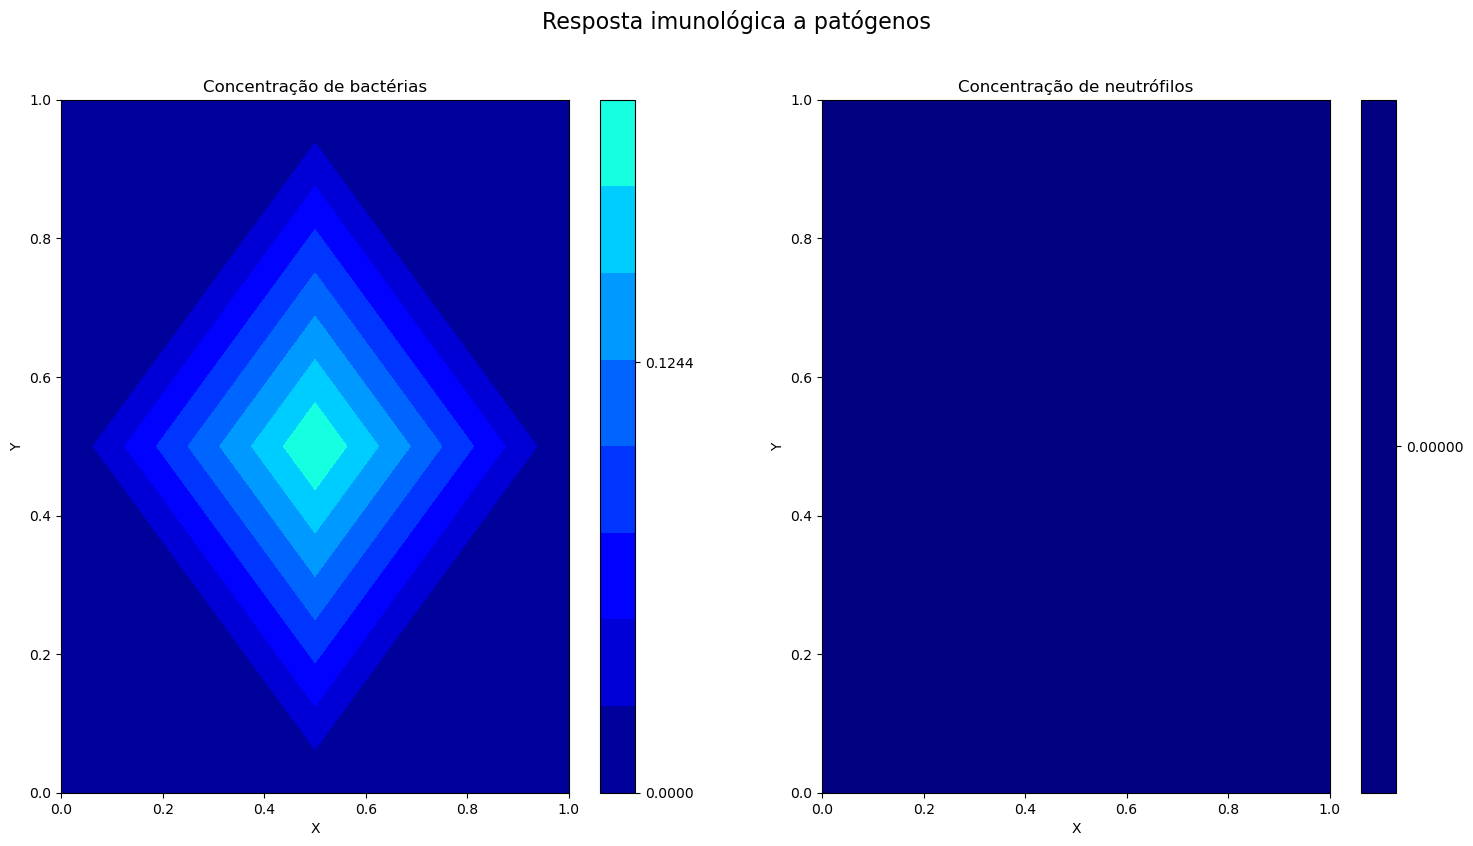

In [7]:
import matplotlib.pyplot as plt

x = np.linspace(x_dom[0], x_dom[1], num=size_x + 1, endpoint=True)
y = np.linspace(y_dom[0], y_dom[1], num=size_y + 1, endpoint=True)
t = np.linspace(t_dom[0], t_dom[1], num=size_tt + 1, endpoint=True)

X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=[18, 9])

fig.suptitle("Resposta imunológica a patógenos", fontsize=16)


vmin = 0
vmax = np.max(Cb[-1])

# Plotango 3D
ax = fig.add_subplot(1, 2, 1)

contour = ax.contourf(X, Y, Cb[0], cmap="jet", vmin=vmin, vmax=vmax)
ax.set_title("Concentração de bactérias")
ax.set_xlabel("X")
ax.set_ylabel("Y")
colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

# Plotando 2D

vmin = 0
vmax = np.max(Cn[-1])

ax = fig.add_subplot(1, 2, 2)

contour = ax.contourf(X, Y, Cn[0], cmap="jet", vmin=vmin, vmax=vmax)
ax.set_title("Concentração de neutrófilos")
ax.set_xlabel("X")
ax.set_ylabel("Y")

colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

plt.show()

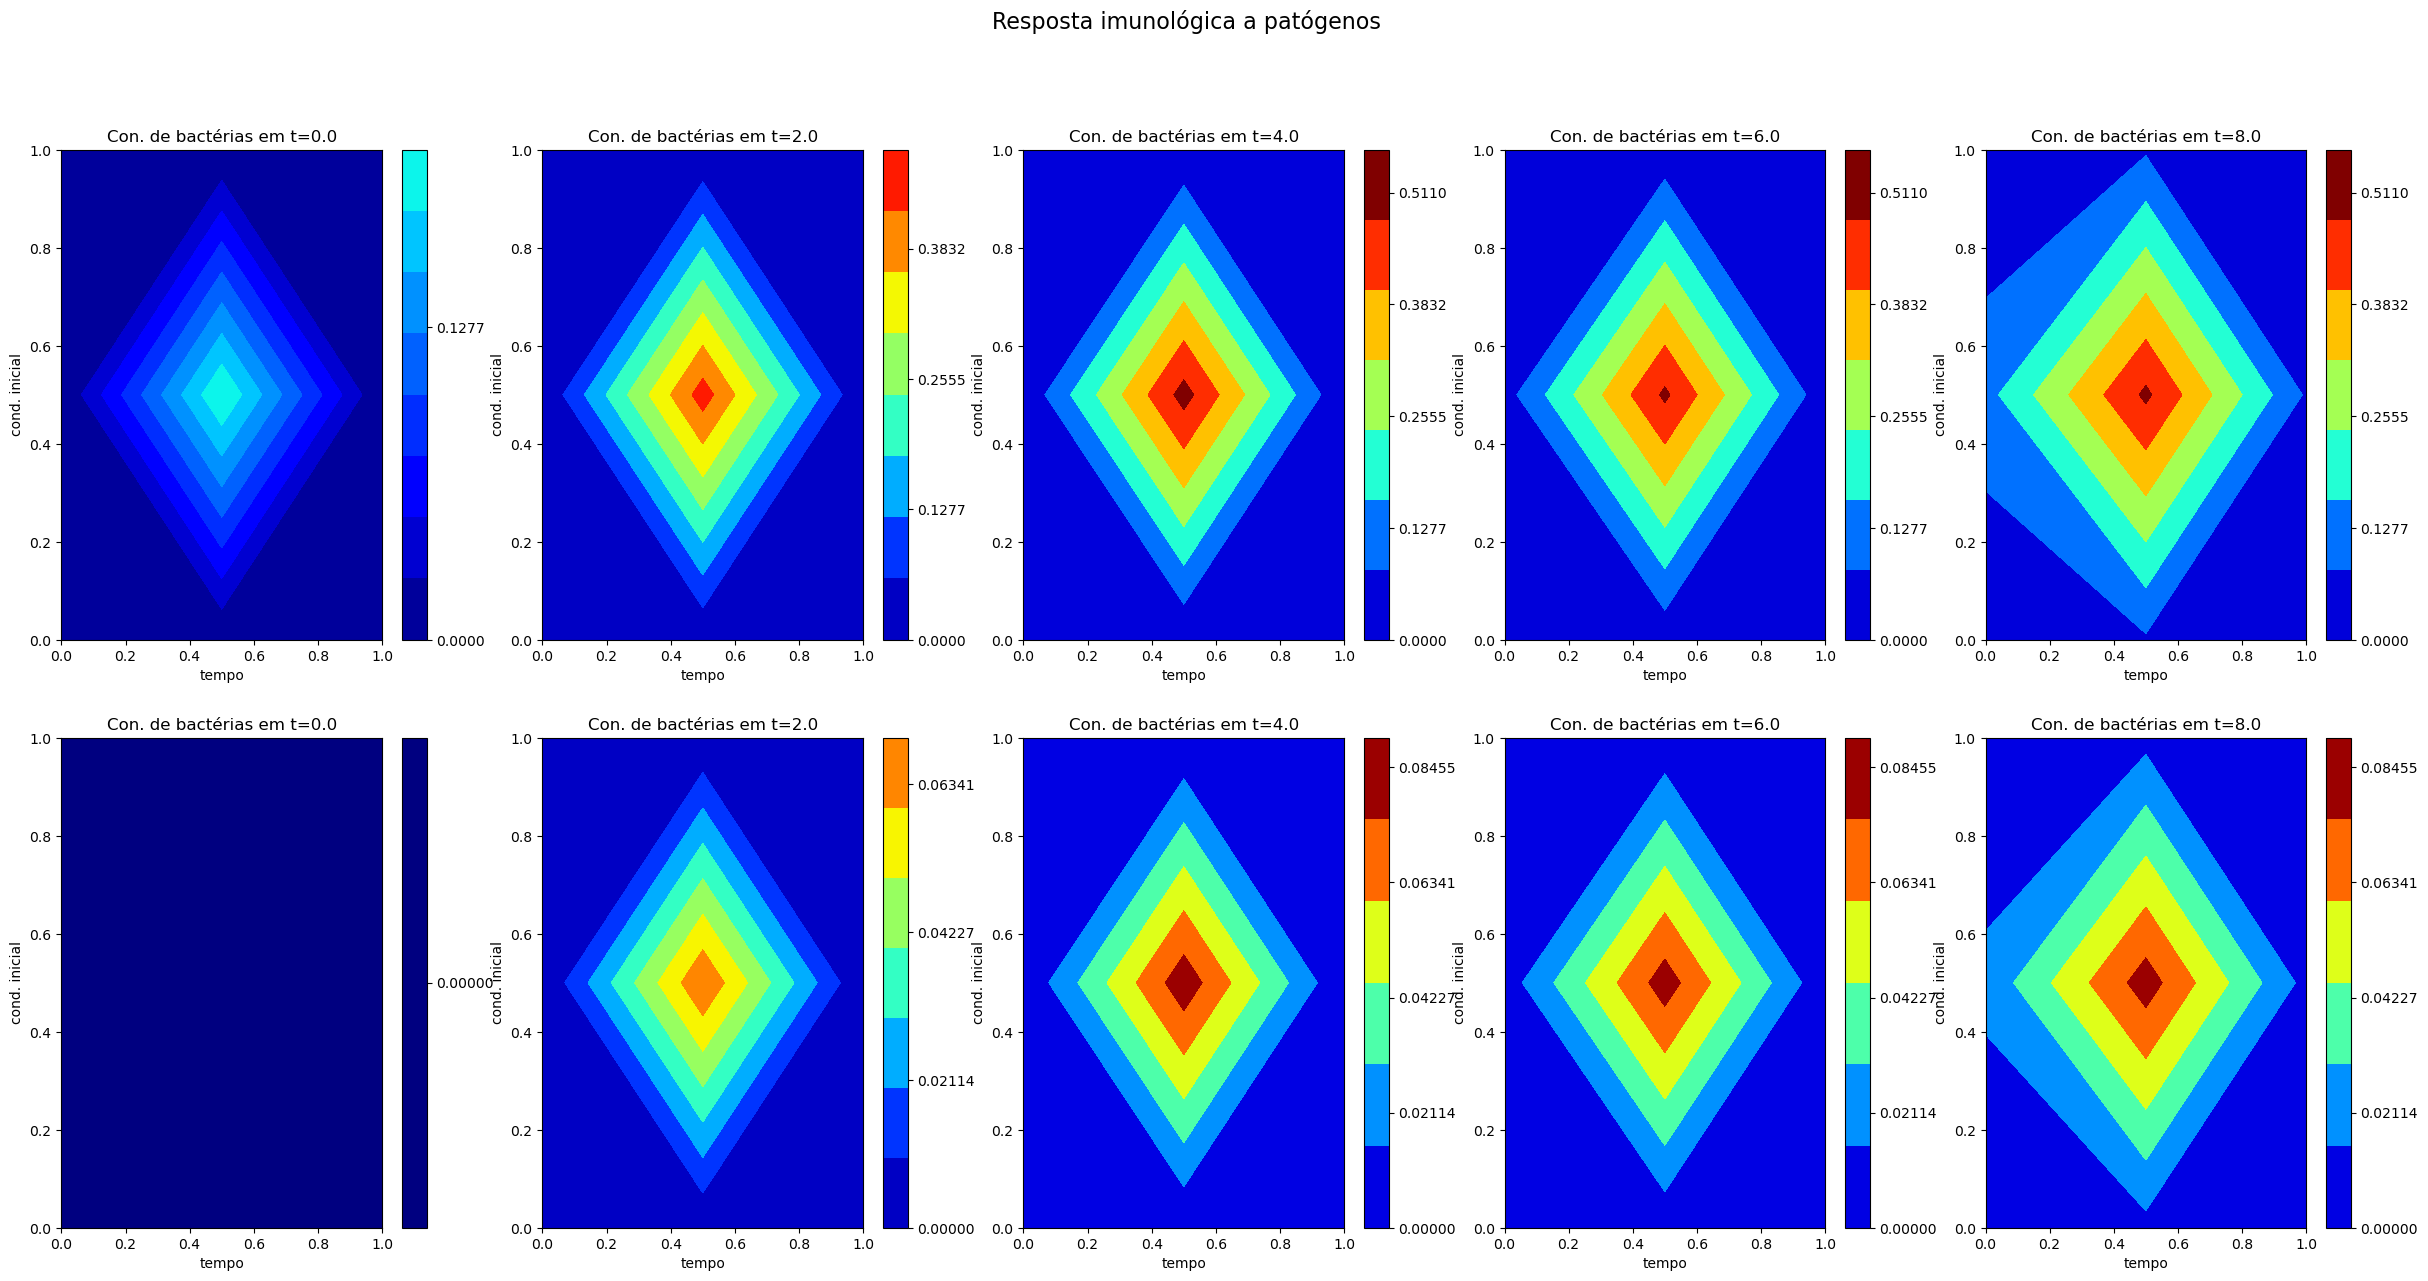

In [8]:
x = np.linspace(x_dom[0], x_dom[1], num=size_x + 1, endpoint=True)
y = np.linspace(y_dom[0], y_dom[1], num=size_y + 1, endpoint=True)
t = np.linspace(t_dom[0], t_dom[1], num=size_tt + 1, endpoint=True)

X, Y = np.meshgrid(x, y)

time_plot = np.linspace(0, len(t), num=5, endpoint=False, dtype=int)

fig = plt.figure(figsize=[6 * len(time_plot), 14])

fig.suptitle("Resposta imunológica a patógenos", fontsize=16)


for i, time in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(2, len(time_plot), i + 1)

    vmin = np.min(Cb)
    vmax = np.max(Cb)

    contour = ax.contourf(
        X,
        Y,
        Cb[time],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("Con. de bactérias em t={}".format(t[time]))
    ax.set_xlabel("tempo")
    ax.set_ylabel("cond. inicial")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

for i, time in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(2, len(time_plot), i + len(time_plot) + 1)

    vmin = np.min(Cn)
    vmax = np.max(Cn)

    contour = ax.contourf(
        X,
        Y,
        Cn[time],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("Con. de bactérias em t={}".format(t[time]))
    ax.set_xlabel("tempo")
    ax.set_ylabel("cond. inicial")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

plt.show()